# Volatility Lab: Análisis Integral de Volatilidad con SPY (S&P 500)

En este notebook construiremos un laboratorio de volatilidad usando datos reales del ETF **SPY**, que replica el índice S&P 500.

El objetivo es entender y visualizar cómo se manifiesta la volatilidad en los mercados financieros desde distintos ángulos:

1. **Volatilidad histórica** del precio de SPY.
2. **Volatilidad implícita de una opción real** usando el modelo de Black–Scholes–Merton.
3. **Sesgo de volatilidad (skew)**: cómo cambia la volatilidad implícita con el strike.
4. **Estructura temporal (term structure)**: cómo cambia la volatilidad implícita con el tiempo a vencimiento.
5. **Superficie de volatilidad**: volatilidad implícita como función conjunta de strike y vencimiento.
6. **Impacto de la volatilidad en estrategias con opciones** (ejemplo con una opción europea).

Este notebook combina:
- Descarga de datos en tiempo real desde Yahoo! Finance (`yfinance`).
- Herramientas de análisis en Python (`pandas`, `numpy`, `matplotlib`).
- Modelos cuantitativos (Black–Scholes–Merton).
- Visualizaciones 2D y 3D de volatilidad.

El activo principal será **SPY**, un ETF muy líquido y ampliamente utilizado en estudios cuantitativos.


# Código: Imports y Configuración Global

In [1]:
# Librerías
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime

# Estilo de gráficos
plt.style.use("seaborn-v0_8")

# Activo principal
TICKER = "SPY"

print(f"Volatility Lab usando el activo: {TICKER}")


Volatility Lab usando el activo: SPY


#Sección de Volatilidad Histórica

## 1. Volatilidad Histórica de SPY

En esta sección:

- Descargamos precios históricos diarios de SPY.
- Calculamos **retornos logarítmicos**.
- Estimamos la **volatilidad diaria y anualizada**.
- Construimos una volatilidad **móvil (rolling)**.
- Comparamos volatilidad anualizada usando distintas frecuencias de muestreo.



#Descarga de precios y retornos

In [2]:
# Rango de fechas para volatilidad histórica (últimos 5 años)
fecha_fin = datetime.today().date()
fecha_inicio = fecha_fin.replace(year=fecha_fin.year - 5)

print(f"Descargando datos de {TICKER} desde {fecha_inicio} hasta {fecha_fin}...")

precios = yf.download(
    TICKER,
    start=str(fecha_inicio),
    end=str(fecha_fin),
    interval="1d",
    auto_adjust=True,
    progress=False
)

precios.head()


Descargando datos de SPY desde 2020-11-20 hasta 2025-11-20...


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2020-11-20,331.260223,333.488340,331.185655,333.283242,70417300
2020-11-23,333.245941,334.513831,330.831389,333.078141,63230600
2020-11-24,338.615692,339.165722,334.951915,335.809579,62415900
2020-11-25,338.093689,338.559819,336.993628,338.531853,45330900
2020-11-27,339.035278,339.510712,338.019089,339.193747,28514100


# Retornos y volatilidad diaria/anual

In [3]:
# Cálculo de retornos logarítmicos
precios["Retornos"] = np.log(precios["Close"] / precios["Close"].shift(1))
precios.dropna(inplace=True)

# Volatilidad diaria y anualizada
dias_trading = 252
vol_diaria = precios["Retornos"].std()
vol_anual = vol_diaria * np.sqrt(dias_trading)

print(f"Volatilidad diaria de SPY:     {vol_diaria:.4f}")
print(f"Volatilidad anualizada de SPY: {vol_anual:.4f}")


Volatilidad diaria de SPY:     0.0108
Volatilidad anualizada de SPY: 0.1707


#Gráficos de precio, retornos y volatilidad rolling

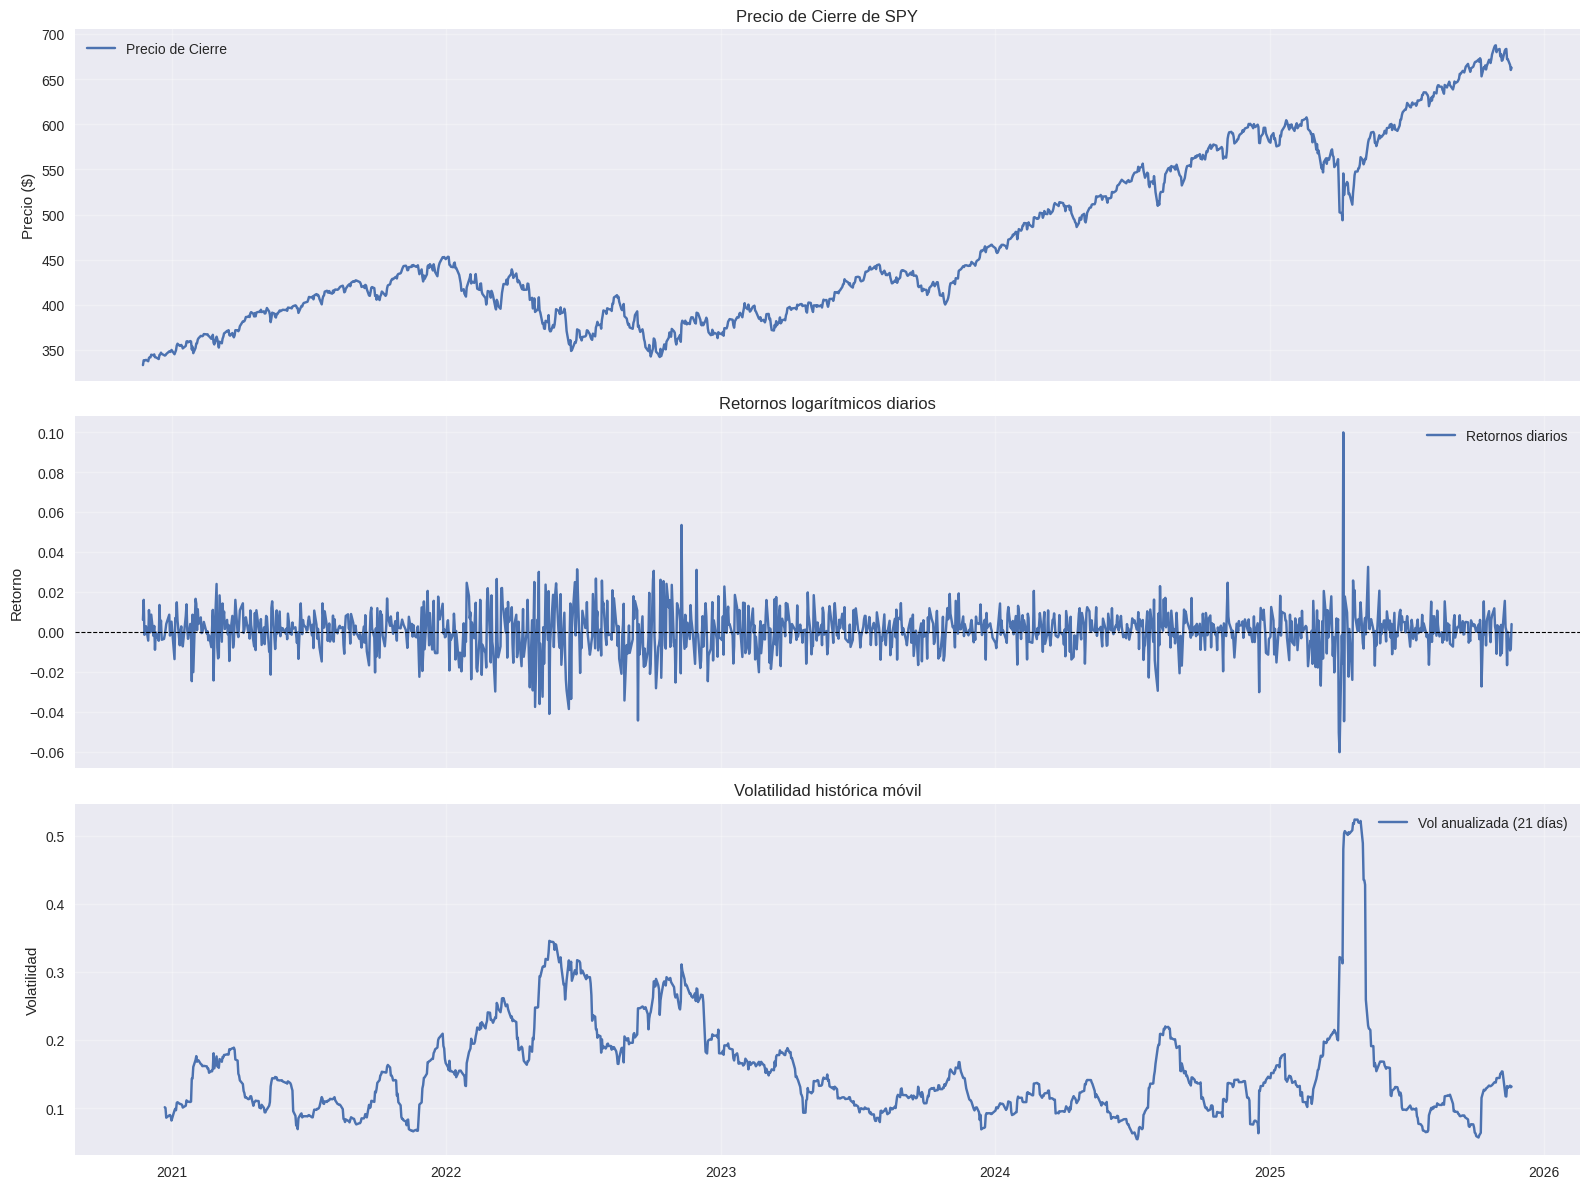

In [4]:
ventana_rolling = 21  # ~1 mes de trading

precios["Vol_rolling"] = (
    precios["Retornos"]
    .rolling(window=ventana_rolling, min_periods=ventana_rolling)
    .std() * np.sqrt(dias_trading)
)

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# 1) Precio
axes[0].plot(precios.index, precios["Close"], label="Precio de Cierre")
axes[0].set_title(f"Precio de Cierre de {TICKER}")
axes[0].set_ylabel("Precio ($)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 2) Retornos diarios
axes[1].plot(precios.index, precios["Retornos"], label="Retornos diarios")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)
axes[1].set_title("Retornos logarítmicos diarios")
axes[1].set_ylabel("Retorno")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 3) Volatilidad rolling
axes[2].plot(precios.index, precios["Vol_rolling"], label=f"Vol anualizada ({ventana_rolling} días)")
axes[2].set_title("Volatilidad histórica móvil")
axes[2].set_ylabel("Volatilidad")
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()


# Comparación de volatilidad por intervalo

In [5]:
intervalos = {
    "1d": ("1 Día", "1y", dias_trading),
    "1wk": ("1 Semana", "3y", 52),
    "1mo": ("1 Mes", "10y", 12),
}

vols_intervalos = {}

for intervalo, (nombre, periodo, factor) in intervalos.items():
    df = yf.download(
        TICKER,
        period=periodo,
        interval=intervalo,
        auto_adjust=True,
        progress=False
    )
    df["Retornos"] = np.log(df["Close"] / df["Close"].shift(1))
    df.dropna(inplace=True)

    vol = df["Retornos"].std() * np.sqrt(factor)
    vols_intervalos[nombre] = vol
    print(f"{nombre:<10} -> Volatilidad anualizada: {vol:.4f}")

vols_intervalos


1 Día      -> Volatilidad anualizada: 0.1950
1 Semana   -> Volatilidad anualizada: 0.1452
1 Mes      -> Volatilidad anualizada: 0.1546


{'1 Día': np.float64(0.19496714634009654),
 '1 Semana': np.float64(0.14521065603912414),
 '1 Mes': np.float64(0.15462760512277224)}

#Gráfico de barras de volatilidad por intervalo

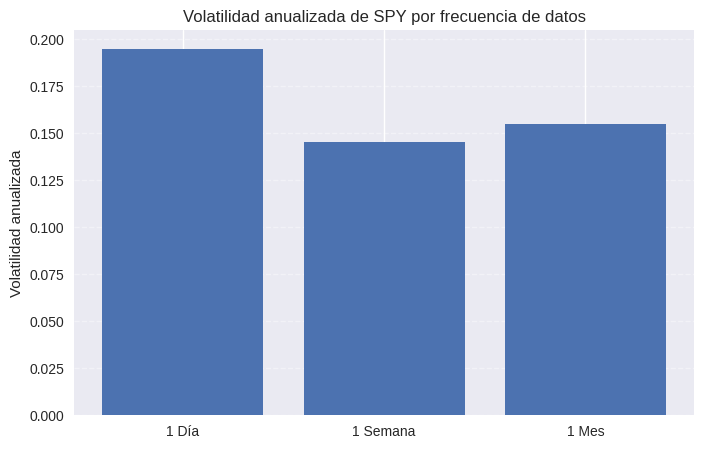

In [6]:
labels = list(vols_intervalos.keys())
vals = [vols_intervalos[k] for k in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, vals)
plt.title(f"Volatilidad anualizada de {TICKER} por frecuencia de datos")
plt.ylabel("Volatilidad anualizada")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


## 2. Volatilidad Implícita de una Opción Real de SPY

Ahora pasamos de la volatilidad histórica a la **volatilidad implícita**:

- Descargamos la cadena de opciones de SPY desde Yahoo! Finance.
- Elegimos una opción **ATM** (At-The-Money) con vencimiento cercano.
- Calculamos su precio teórico usando el modelo de **Black–Scholes–Merton (BSM)**.
- Recuperamos la **volatilidad implícita** resolviendo la ecuación inversa:
  
> Encontrar la sigma que hace que el precio de BSM coincida con el precio de mercado.


Función BSM e Implied Vol

In [7]:
def precio_opcion_bsm(S, K, T, r, sigma, q=0.0, tipo="call"):
    """
    Precio de una opción europea usando el modelo Black–Scholes–Merton.
    """
    if T <= 0 or sigma <= 0:
        if tipo == "call":
            return max(0.0, S - K)
        else:
            return max(0.0, K - S)

    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if tipo == "call":
        precio = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        precio = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

    return precio


def volatilidad_implicita(precio_mercado, S, K, T, r, q=0.0, tipo="call"):
    """
    Estima la volatilidad implícita que iguala el precio BSM con el precio de mercado.
    """
    def error(sigma):
        precio_teorico = precio_opcion_bsm(S, K, T, r, sigma, q, tipo)
        return abs(precio_teorico - precio_mercado)

    resultado = minimize_scalar(error, bounds=(0.001, 5.0), method="bounded")
    if resultado.success:
        return resultado.x
    else:
        return np.nan


#Descargar opciones SPY y seleccionar contrato ATM

In [8]:
# Instancia del ticker
tk = yf.Ticker(TICKER)

# Fechas de vencimiento disponibles
fechas_opts = tk.options
print("Fechas de vencimiento disponibles:")
for i, f in enumerate(fechas_opts):
    print(i, "->", f)

# Elegimos un vencimiento cercano (por ejemplo, índice 2 si existe)
indice_vencimiento = min(2, len(fechas_opts) - 1)
fecha_objetivo = fechas_opts[indice_vencimiento]
print("\nUsando vencimiento:", fecha_objetivo)

# Cadena de opciones para esa fecha
chain = tk.option_chain(date=fecha_objetivo)
calls = chain.calls.copy()
puts = chain.puts.copy()

# Precio spot aproximado
spot = tk.history(period="1d")["Close"].iloc[-1]
print("Spot aproximado de SPY:", spot)

# Elegir call ATM (strike más cercano al spot)
calls["distancia"] = (calls["strike"] - spot).abs()
call_atm = calls.sort_values("distancia").iloc[0]

strike_atm = call_atm["strike"]
precio_mercado_call = call_atm["lastPrice"]
iv_yfinance_call = call_atm["impliedVolatility"]

print(f"\nCall ATM seleccionada (aprox.):")
print(f"Strike: {strike_atm}")
print(f"Precio de mercado (lastPrice): {precio_mercado_call}")
print(f"IV según yfinance: {iv_yfinance_call*100:.2f}%")


Fechas de vencimiento disponibles:
0 -> 2025-11-20
1 -> 2025-11-21
2 -> 2025-11-24
3 -> 2025-11-25
4 -> 2025-11-26
5 -> 2025-11-28
6 -> 2025-12-05
7 -> 2025-12-12
8 -> 2025-12-19
9 -> 2025-12-26
10 -> 2025-12-31
11 -> 2026-01-02
12 -> 2026-01-16
13 -> 2026-01-30
14 -> 2026-02-20
15 -> 2026-02-27
16 -> 2026-03-20
17 -> 2026-03-31
18 -> 2026-04-30
19 -> 2026-06-18
20 -> 2026-06-30
21 -> 2026-09-18
22 -> 2026-09-30
23 -> 2026-12-18
24 -> 2027-01-15
25 -> 2027-03-19
26 -> 2027-06-17
27 -> 2027-12-17
28 -> 2028-01-21

Usando vencimiento: 2025-11-24
Spot aproximado de SPY: 662.6300048828125

Call ATM seleccionada (aprox.):
Strike: 663.0
Precio de mercado (lastPrice): 6.46
IV según yfinance: 22.37%


#Calcular T y comparar I.V. teórica vs de mercado

In [10]:
# Tiempo a vencimiento en años
fecha_vencimiento_dt = pd.to_datetime(fecha_objetivo)
hoy = datetime.now()
T_years = (fecha_vencimiento_dt - hoy).days / 365

# Supongamos tasa libre de riesgo aproximada del 5%
r = 0.05
q = 0.0
tipo = "call"

# Precio teórico usando la IV de yfinance
precio_teorico_yf = precio_opcion_bsm(
    S=spot,
    K=strike_atm,
    T=T_years,
    r=r,
    sigma=iv_yfinance_call,
    q=q,
    tipo=tipo
)

# Calcular I.V. "a mano"
iv_calc = volatilidad_implicita(
    precio_mercado=precio_mercado_call,
    S=spot,
    K=strike_atm,
    T=T_years,
    r=r,
    q=q,
    tipo=tipo
)

print("=== Comparación de volatilidad implícita para una Call ATM ===")
print(f"I.V. (yfinance):      {iv_yfinance_call*100:.4f}%")
print(f"I.V. (calculada):     {iv_calc*100:.4f}%")
print(f"Precio teórico BSM (usando I.V. yfinance): {precio_teorico_yf:.4f}")
print(f"Precio de mercado (lastPrice):           {precio_mercado_call:.4f}")


=== Comparación de volatilidad implícita para una Call ATM ===
I.V. (yfinance):      22.3702%
I.V. (calculada):     27.1565%
Precio teórico BSM (usando I.V. yfinance): 5.3129
Precio de mercado (lastPrice):           6.4600


#Sesgo de Volatilidad (Skew)
## 3. Sesgo de Volatilidad (Volatility Skew) en SPY

En esta sección analizamos cómo varía la volatilidad implícita con el **strike** para diferentes vencimientos.

- Skew de **calls** y **puts**.
- Comparación entre vencimientos de **corto, mediano y largo plazo**.
- Interpretación típica en índices: **reverse skew** (puts OTM más caros en términos de IV).

#Función para cargar opciones y graficar skew

In [11]:
# Cargar todas las opciones (calls y puts) para todas las fechas
asset = yf.Ticker(TICKER)
fechas_disponibles = asset.options

opciones_total_lista = []
for f in fechas_disponibles:
    ch = asset.option_chain(date=f)
    c = ch.calls.copy()
    p = ch.puts.copy()
    c["Type"] = "call"
    p["Type"] = "put"
    c["Expiration"] = f
    p["Expiration"] = f
    opciones_total_lista.append(pd.concat([c, p], axis=0))

opciones_totales = pd.concat(opciones_total_lista, axis=0).reset_index(drop=True)
opciones_totales["Expiration"] = pd.to_datetime(opciones_totales["Expiration"])
opciones_totales = opciones_totales.dropna(subset=["impliedVolatility"])

len(fechas_disponibles), opciones_totales.head()


(29,
        contractSymbol             lastTradeDate  strike  lastPrice    bid  \
 0  SPY251120C00575000 2025-11-19 16:23:24+00:00   575.0      87.06  85.87   
 1  SPY251120C00595000 2025-11-19 18:40:17+00:00   595.0      68.41  65.88   
 2  SPY251120C00600000 2025-11-19 18:56:27+00:00   600.0      62.34  60.89   
 3  SPY251120C00625000 2025-11-19 16:49:03+00:00   625.0      37.20  35.93   
 4  SPY251120C00630000 2025-11-19 20:21:02+00:00   630.0      34.10  32.88   
 
      ask    change  percentChange  volume  openInterest  impliedVolatility  \
 0  89.40  2.339996       2.762035     2.0             2           0.843752   
 1  69.41 -8.279999     -10.796712    11.0             2           0.718753   
 2  64.42  2.610001       4.369665    84.0             2           0.703128   
 3  39.47 -0.630001      -1.665348     4.0             2           0.943116   
 4  33.11  1.469997       4.505049    28.0             6           0.571782   
 
    inTheMoney contractSize currency  Type Expira

#Seleccionar 3 vencimientos y graficar skew

In [12]:
print("Fechas de vencimiento disponibles:")
for i, f in enumerate(fechas_disponibles):
    print(i, "->", f)

# Elegimos: corto, medio, largo plazo
idx_short = min(3, len(fechas_disponibles) - 1)
idx_mid   = len(fechas_disponibles) // 2
idx_long  = len(fechas_disponibles) - 1

seleccion_fechas = [
    fechas_disponibles[idx_short],
    fechas_disponibles[idx_mid],
    fechas_disponibles[idx_long],
]

print("\nUsaremos vencimientos:")
seleccion_fechas



Fechas de vencimiento disponibles:
0 -> 2025-11-20
1 -> 2025-11-21
2 -> 2025-11-24
3 -> 2025-11-25
4 -> 2025-11-26
5 -> 2025-11-28
6 -> 2025-12-05
7 -> 2025-12-12
8 -> 2025-12-19
9 -> 2025-12-26
10 -> 2025-12-31
11 -> 2026-01-02
12 -> 2026-01-16
13 -> 2026-01-30
14 -> 2026-02-20
15 -> 2026-02-27
16 -> 2026-03-20
17 -> 2026-03-31
18 -> 2026-04-30
19 -> 2026-06-18
20 -> 2026-06-30
21 -> 2026-09-18
22 -> 2026-09-30
23 -> 2026-12-18
24 -> 2027-01-15
25 -> 2027-03-19
26 -> 2027-06-17
27 -> 2027-12-17
28 -> 2028-01-21

Usaremos vencimientos:


['2025-11-25', '2026-02-20', '2028-01-21']

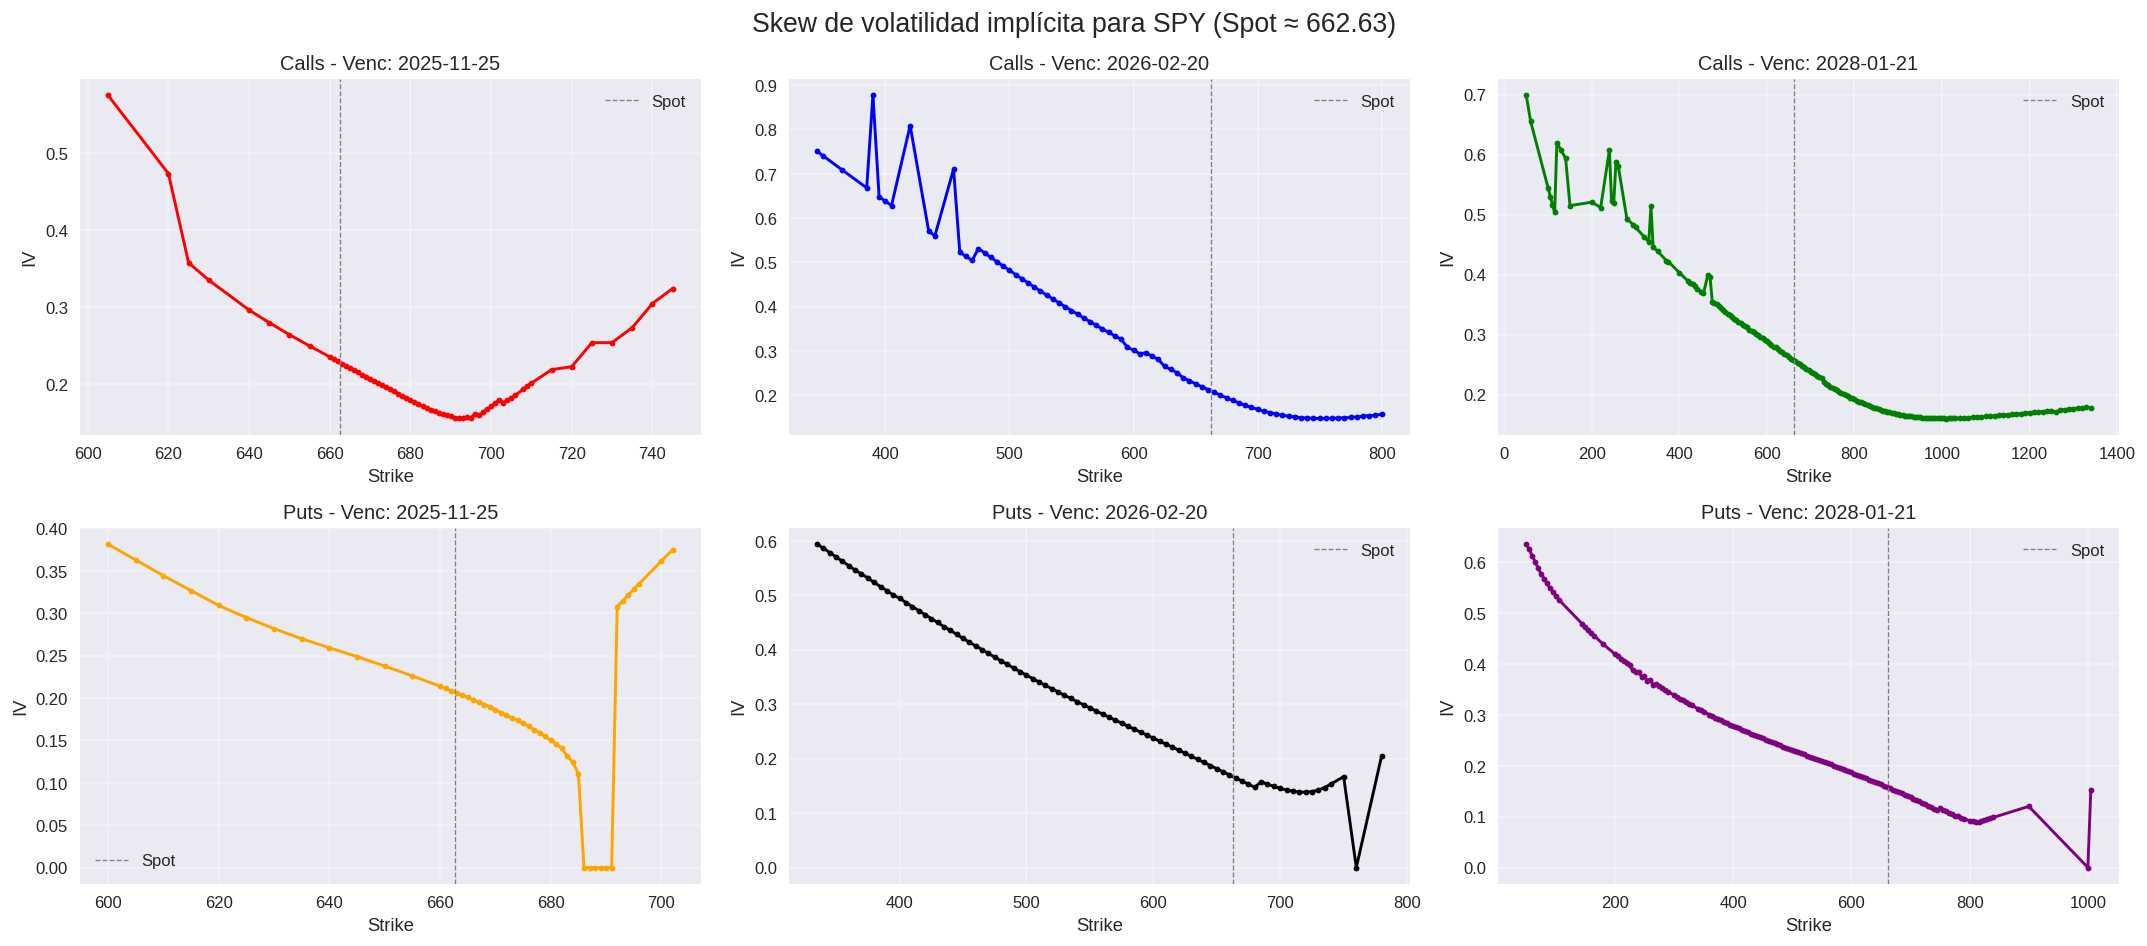

In [13]:
def separar_calls_puts_por_fecha(df, fecha):
    sub = df[df["Expiration"] == pd.to_datetime(fecha)].copy()
    calls = sub[sub["Type"] == "call"].dropna(subset=["impliedVolatility"])
    puts  = sub[sub["Type"] == "put"].dropna(subset=["impliedVolatility"])
    return calls, puts

calls_1, puts_1 = separar_calls_puts_por_fecha(opciones_totales, seleccion_fechas[0])
calls_2, puts_2 = separar_calls_puts_por_fecha(opciones_totales, seleccion_fechas[1])
calls_3, puts_3 = separar_calls_puts_por_fecha(opciones_totales, seleccion_fechas[2])

datos_combinados = [
    (calls_1, seleccion_fechas[0], "Calls"),
    (calls_2, seleccion_fechas[1], "Calls"),
    (calls_3, seleccion_fechas[2], "Calls"),
    (puts_1,  seleccion_fechas[0], "Puts"),
    (puts_2,  seleccion_fechas[1], "Puts"),
    (puts_3,  seleccion_fechas[2], "Puts"),
]

spot_spy = asset.history(period="1d")["Close"].iloc[-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=120)
axes = axes.flatten()
colores = ["red", "blue", "green", "orange", "black", "purple"]

for i, (df, fecha, tipo) in enumerate(datos_combinados):
    ax = axes[i]
    ax.plot(df["strike"], df["impliedVolatility"], color=colores[i], marker=".")
    ax.axvline(spot_spy, color="grey", linestyle="--", linewidth=0.8, label="Spot")
    ax.set_title(f"{tipo} - Venc: {fecha}")
    ax.set_xlabel("Strike")
    ax.set_ylabel("IV")
    ax.grid(True, alpha=0.4)
    ax.legend()

plt.suptitle(f"Skew de volatilidad implícita para {TICKER} (Spot ≈ {spot_spy:.2f})", fontsize=16)
plt.tight_layout()
plt.show()


## 4. Estructura Temporal de la Volatilidad Implícita (Term Structure)

Ahora fijamos un strike aproximadamente **ATM** y analizamos cómo cambia la volatilidad implícita con el **tiempo a vencimiento**:

- Term structure de **Calls ATM**.
- Term structure de **Puts ATM**.

Esto nos da una idea de cómo el mercado “precia” la volatilidad en distintos horizontes temporales.


#Term structure ATM

Strike ATM seleccionado: 663.00


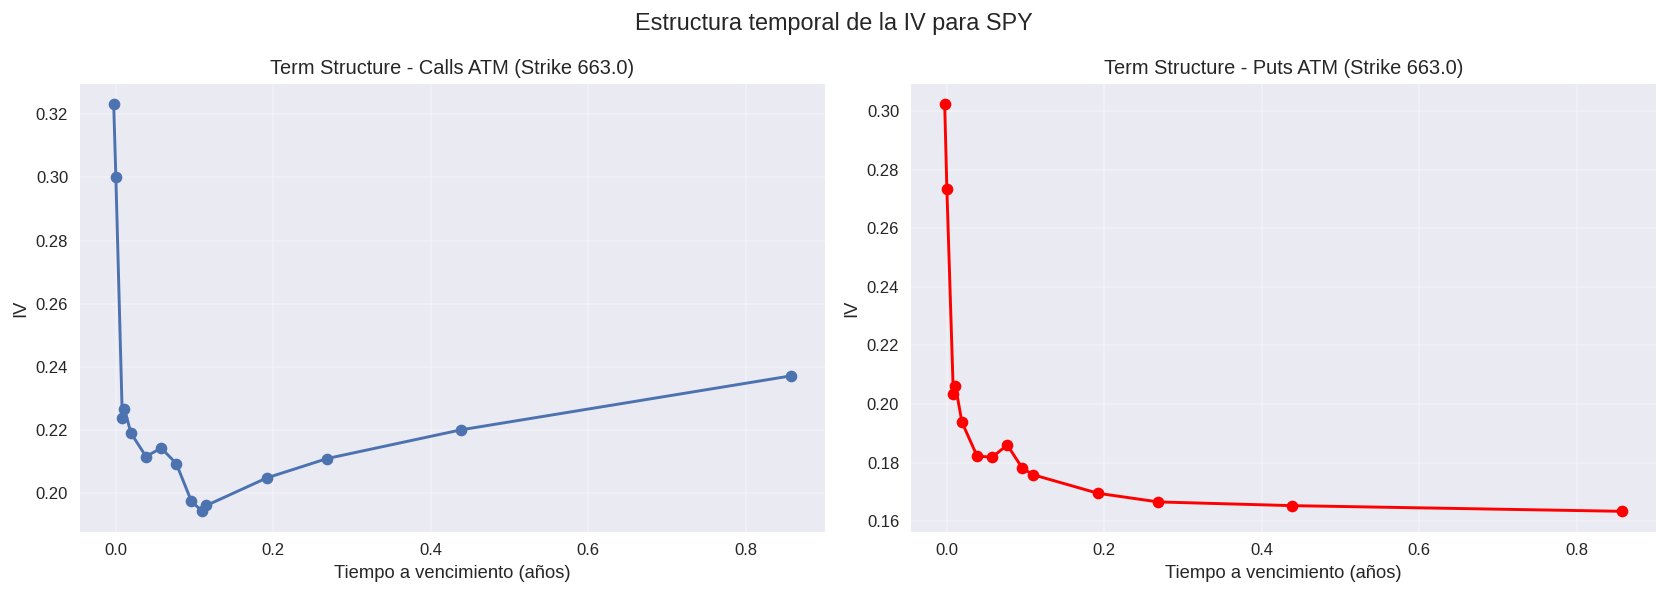

In [14]:
# Strike ATM más cercano al spot
idx_atm = (opciones_totales["strike"] - spot_spy).abs().idxmin()
strike_atm_spy = opciones_totales.loc[idx_atm, "strike"]
print(f"Strike ATM seleccionado: {strike_atm_spy:.2f}")

calls_atm = opciones_totales[
    (opciones_totales["strike"] == strike_atm_spy) &
    (opciones_totales["Type"] == "call")
].copy()

puts_atm = opciones_totales[
    (opciones_totales["strike"] == strike_atm_spy) &
    (opciones_totales["Type"] == "put")
].copy()

calls_atm = calls_atm.sort_values("Expiration")
puts_atm  = puts_atm.sort_values("Expiration")

# Tiempo a vencimiento en años
hoy = datetime.now()
calls_atm["T_years"] = (calls_atm["Expiration"] - hoy).dt.days / 365
puts_atm["T_years"]  = (puts_atm["Expiration"] - hoy).dt.days / 365

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

axes[0].plot(calls_atm["T_years"], calls_atm["impliedVolatility"], marker="o")
axes[0].set_title(f"Term Structure - Calls ATM (Strike {strike_atm_spy})")
axes[0].set_xlabel("Tiempo a vencimiento (años)")
axes[0].set_ylabel("IV")
axes[0].grid(True, alpha=0.3)

axes[1].plot(puts_atm["T_years"], puts_atm["impliedVolatility"], marker="o", color="red")
axes[1].set_title(f"Term Structure - Puts ATM (Strike {strike_atm_spy})")
axes[1].set_xlabel("Tiempo a vencimiento (años)")
axes[1].set_ylabel("IV")
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Estructura temporal de la IV para {TICKER}", fontsize=14)
plt.tight_layout()
plt.show()


## 5. Superficie de Volatilidad Implícita

La **superficie de volatilidad** combina:

- Eje X: tiempo a vencimiento (días).
- Eje Y: strike.
- Eje Z: volatilidad implícita.

Es una representación 3D de cómo el mercado valora la volatilidad para cada combinación (strike, vencimiento).


#Construir la superficie (pivot & meshgrid)

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # necesario para gráficos 3D

# Agregar días hasta vencimiento
opciones_totales["daysToExp"] = (opciones_totales["Expiration"] - hoy).dt.days + 1
opciones_totales = opciones_totales[opciones_totales["daysToExp"] > 0]

calls_all = opciones_totales[opciones_totales["Type"] == "call"].copy()
puts_all  = opciones_totales[opciones_totales["Type"] == "put"].copy()

surface_call = calls_all.pivot_table(
    values="impliedVolatility",
    index="strike",
    columns="daysToExp"
).dropna()

surface_put = puts_all.pivot_table(
    values="impliedVolatility",
    index="strike",
    columns="daysToExp"
).dropna()

def crear_mallas(df):
    X, Y = np.meshgrid(df.columns, df.index)  # X: días, Y: strikes
    Z = df.values
    return X, Y, Z

Xc, Yc, Zc = crear_mallas(surface_call)
Xp, Yp, Zp = crear_mallas(surface_put)

Xc.shape, Yc.shape, Zc.shape


((21, 28), (21, 28), (21, 28))

#Graficar Superficie 3D (Calls y Puts)

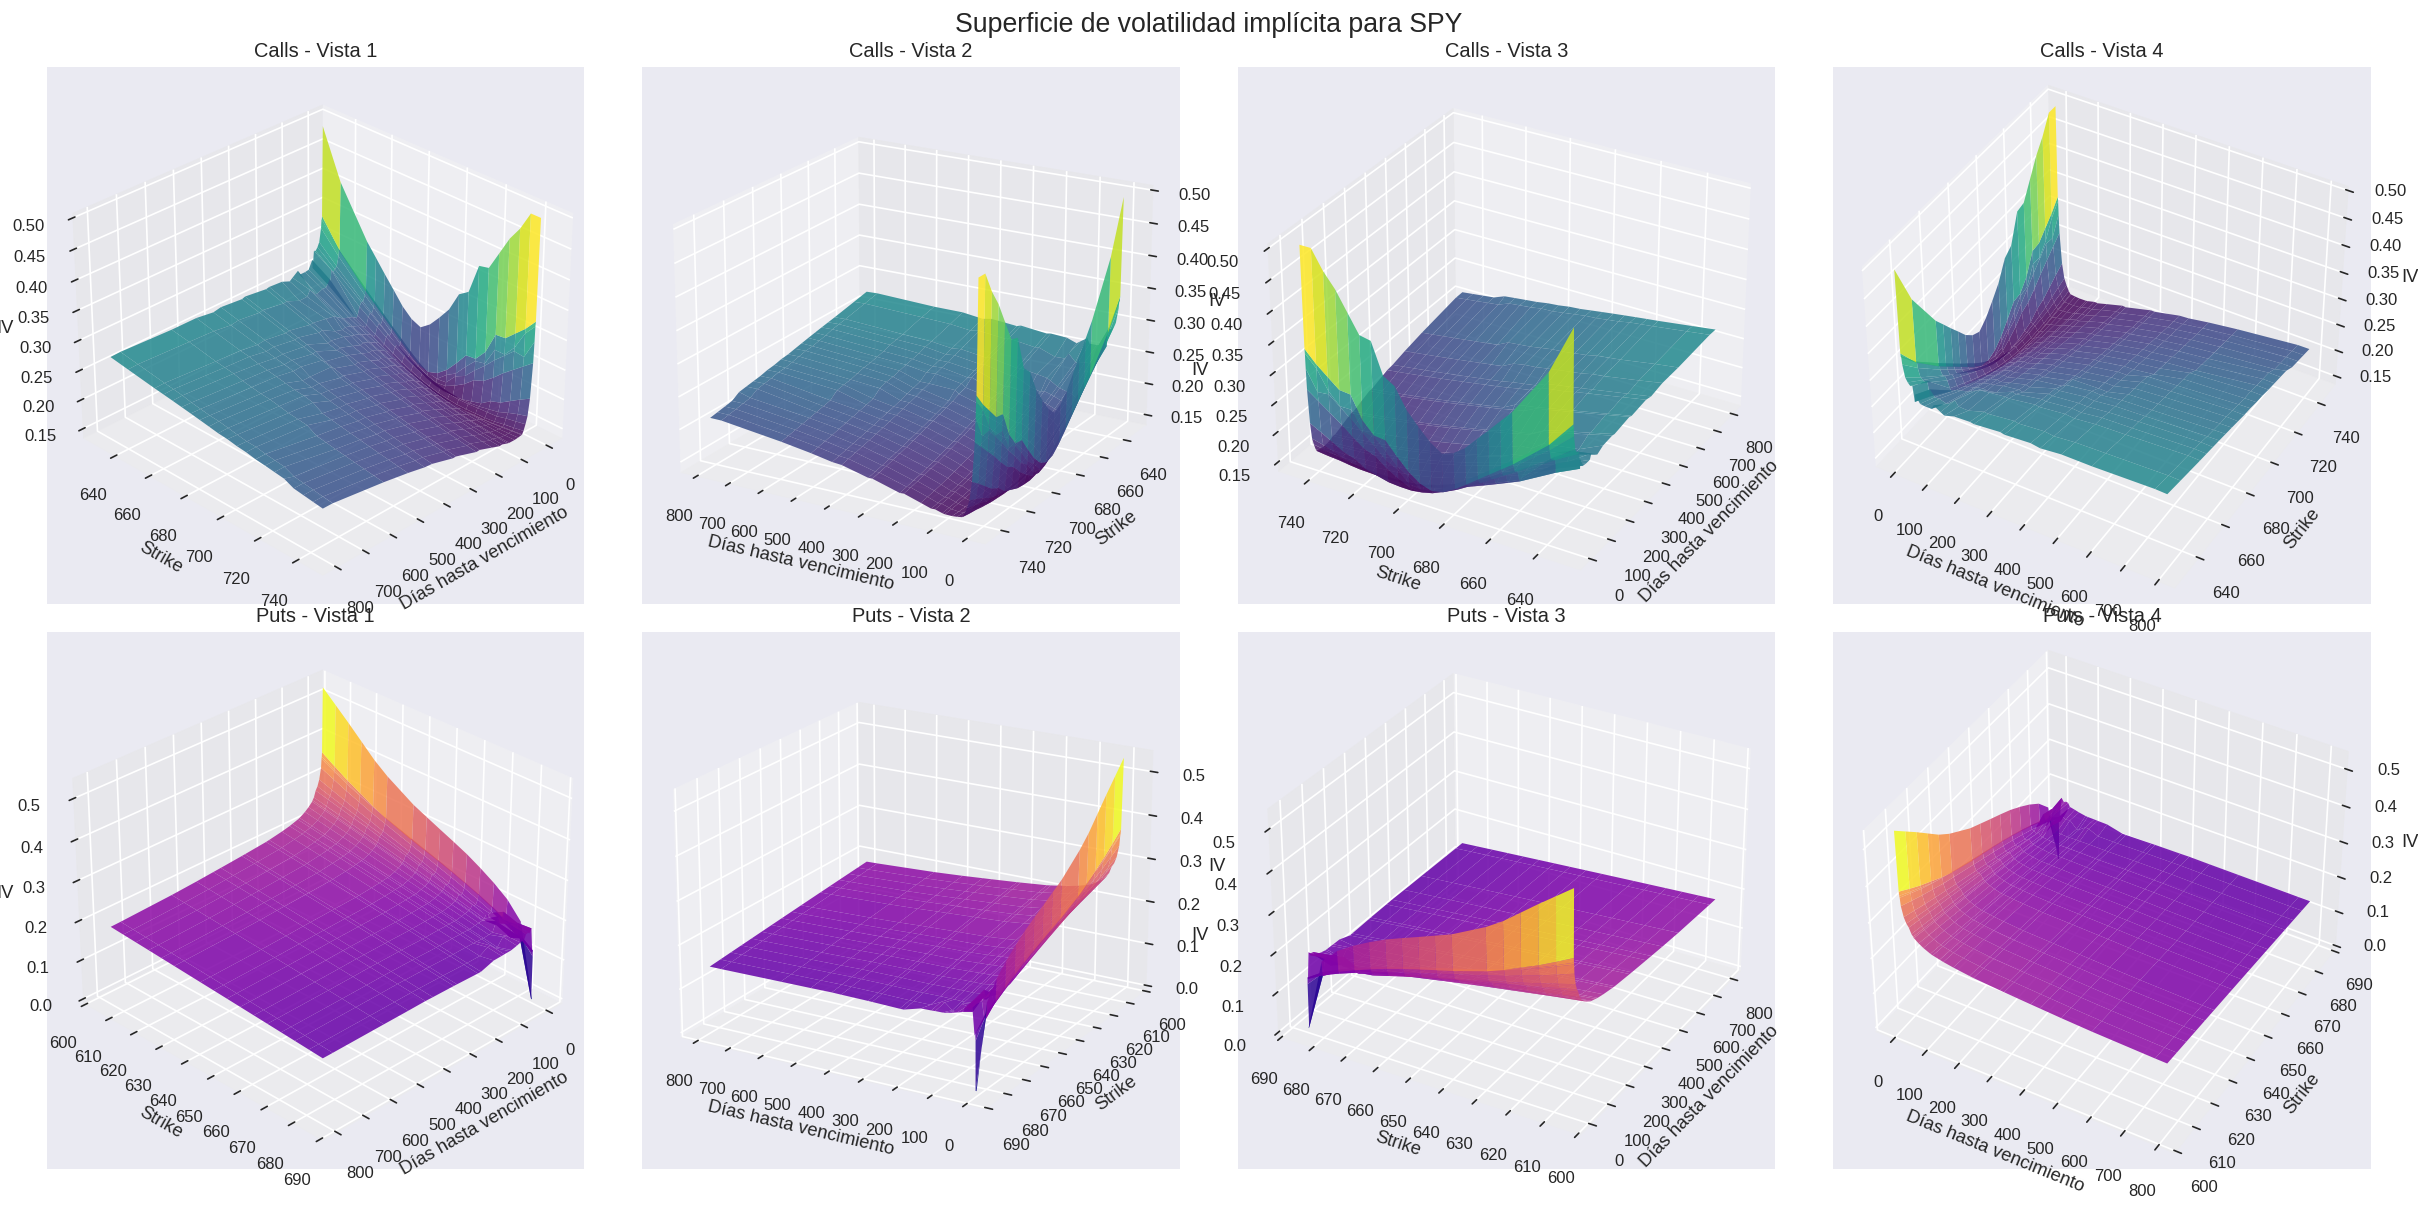

In [17]:
fig = plt.figure(figsize=(20, 10), dpi=120)

elevs = [30, 20, 30, 40]
azims = [45, 120, 210, 300]

# Superficie de Calls
for i in range(4):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.plot_surface(Xc, Yc, Zc, cmap="viridis", alpha=0.85)
    ax.set_title(f"Calls - Vista {i+1}")
    ax.set_xlabel("Días hasta vencimiento")
    ax.set_ylabel("Strike")
    ax.set_zlabel("IV")
    ax.view_init(elev=elevs[i], azim=azims[i])

# Superficie de Puts
for i in range(4):
    ax = fig.add_subplot(2, 4, i + 5, projection="3d")
    ax.plot_surface(Xp, Yp, Zp, cmap="plasma", alpha=0.85)
    ax.set_title(f"Puts - Vista {i+1}")
    ax.set_xlabel("Días hasta vencimiento")
    ax.set_ylabel("Strike")
    ax.set_zlabel("IV")
    ax.view_init(elev=elevs[i], azim=azims[i])

plt.suptitle(f"Superficie de volatilidad implícita para {TICKER}", fontsize=16)
plt.tight_layout()
plt.show()


## 6. Impacto de la Volatilidad en Estrategias con Opciones

Por último, analizamos cómo cambios en la **volatilidad implícita** afectan la ganancia/pérdida de una posición en opciones:

- Tomamos una **opción europea (call o put)**.
- Definimos un escenario inicial (precio, sigma, tiempo).
- Definimos un escenario futuro (nuevo precio del subyacente y nueva sigma).
- Graficamos la **P&L (%)** en función de la volatilidad implícita futura.

Esto ilustra el papel de la **vega**: sensibilidad del precio de la opción a cambios en la volatilidad.


# Escenario de P&L vs Volatilidad Implícita

In [18]:
# Reutilizamos la función black_scholes_merton (precio_opcion_bsm)

# Parámetros iniciales (ejemplo ilustrativo)
S_0    = 400.0     # Precio spot inicial (nivel aproximado de SPY)
K      = 400.0     # Strike ATM
sigma0 = 0.20      # IV inicial 20%
r      = 0.05      # Tasa libre de riesgo
T_0    = 30 / 365  # 30 días
q      = 0.0
tipo   = "put"     # Puede cambiar a "call"

prima_inicial = precio_opcion_bsm(S=S_0, K=K, T=T_0, r=r, sigma=sigma0, q=q, tipo=tipo)
print(f"Prima inicial ({tipo} ATM): {prima_inicial:.4f} USD")

# Escenario futuro
dias_transcurridos = 5
T_nuevo = (30 - dias_transcurridos) / 365
S_nuevo = 380.0    # Por ejemplo, SPY baja de 400 a 380
sigma_escenario = 0.60  # IV futura de ejemplo

prima_nueva = precio_opcion_bsm(S=S_nuevo, K=K, T=T_nuevo, r=r, sigma=sigma_escenario, q=q, tipo=tipo)
ganancia_neta = prima_nueva - prima_inicial
ganancia_pct_escenario = ganancia_neta / prima_inicial * 100

print(f"\nEscenario futuro:")
print(f"Nuevo spot: {S_nuevo}")
print(f"Nueva IV: {sigma_escenario*100:.1f}%")
print(f"Nueva prima: {prima_nueva:.4f} USD")
print(f"G/P (%): {ganancia_pct_escenario:.2f}%")


Prima inicial (put ATM): 8.3330 USD

Escenario futuro:
Nuevo spot: 380.0
Nueva IV: 60.0%
Nueva prima: 34.8006 USD
G/P (%): 317.62%


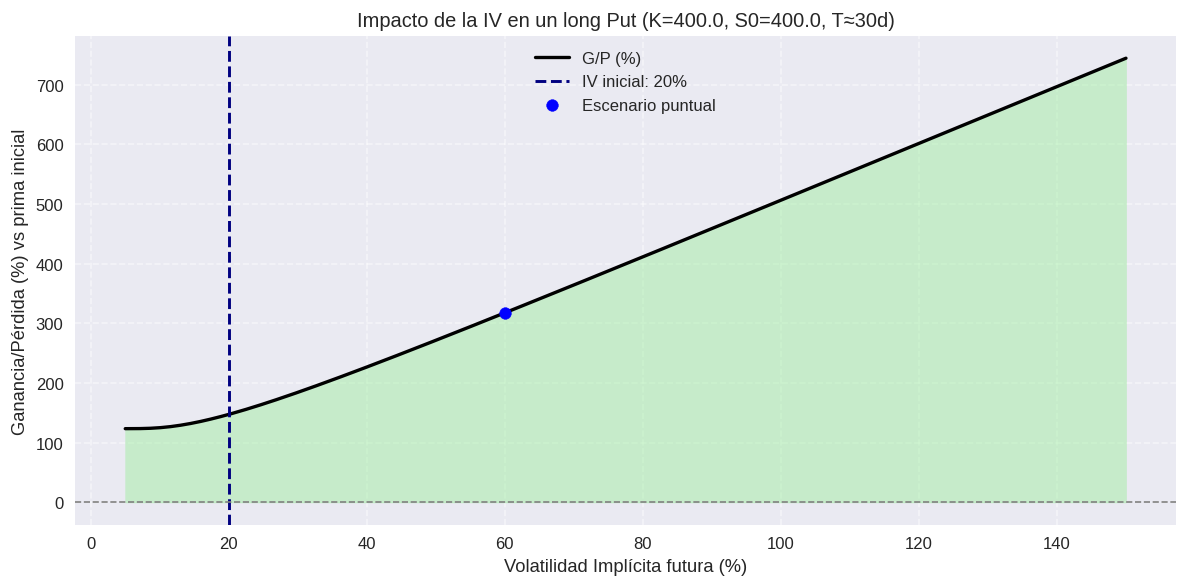

In [19]:
# Curva de P&L en función de IV futura

sigma_min = 0.05
sigma_max = 1.50
n_puntos  = 200

sigmas_fut = np.linspace(sigma_min, sigma_max, n_puntos)
ganancias_pct = []

for sigma_fut in sigmas_fut:
    prima_fut = precio_opcion_bsm(S=S_nuevo, K=K, T=T_nuevo, r=r, sigma=sigma_fut, q=q, tipo=tipo)
    g_pct = (prima_fut - prima_inicial) / prima_inicial * 100
    ganancias_pct.append(g_pct)

sigmas_fut = np.array(sigmas_fut)
ganancias_pct = np.array(ganancias_pct)

plt.figure(figsize=(10, 5), dpi=120)

plt.plot(sigmas_fut * 100, ganancias_pct, color="black", lw=2, label="G/P (%)")
plt.fill_between(sigmas_fut * 100, ganancias_pct, 0, where=(ganancias_pct >= 0),
                 color="lightgreen", alpha=0.4)
plt.fill_between(sigmas_fut * 100, ganancias_pct, 0, where=(ganancias_pct < 0),
                 color="salmon", alpha=0.4)

plt.axvline(sigma0 * 100, color="navy", linestyle="--", label=f"IV inicial: {sigma0*100:.0f}%")
plt.axhline(0, color="gray", linestyle="--", lw=1)

plt.scatter([sigma_escenario * 100], [ganancia_pct_escenario], color="blue", zorder=5,
            label="Escenario puntual")

plt.title(f"Impacto de la IV en un long {tipo.capitalize()} (K={K}, S0={S_0}, T≈30d)")
plt.xlabel("Volatilidad Implícita futura (%)")
plt.ylabel("Ganancia/Pérdida (%) vs prima inicial")
plt.grid(linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 7. Conclusiones

En este laboratorio de volatilidad con datos reales de **SPY** hemos:

- Calculado la **volatilidad histórica** a partir de retornos logarítmicos y visto su dinámica a través del tiempo.
- Estimado la **volatilidad implícita** de una opción real usando el modelo de **Black–Scholes–Merton**.
- Analizado el **sesgo de volatilidad (skew)** para diferentes vencimientos, observando cómo las opciones OTM reflejan el miedo del mercado ante caídas.
- Estudiado la **estructura temporal de la IV (term structure)** para opciones ATM, identificando cómo cambia la expectativa de volatilidad en distintos horizontes temporales.
- Construido y visualizado la **superficie de volatilidad implícita** como función conjunta de strike y tiempo.
- Exploramos el **impacto de cambios en la volatilidad implícita** sobre la ganancia/pérdida de una opción, ilustrando el rol de la **vega**.

Este notebook puede servir como:
- Pieza de portafolio para roles de **Quant / Risk / Data Scientist en Finanzas**.
- Punto de partida para:
  - Calibrar modelos más avanzados de volatilidad.
  - Explorar sonrisas dinámicas en el tiempo.
  - Construir estrategias de trading basadas en spreads de volatilidad.

---

**Ideas de extensiones futuras:**

- Comparar SPY con otros activos (TSLA, QQQ, AAPL) y contrastar sus superficies de volatilidad.
- Incorporar volatilidad **histórica vs implícita** en la misma escala.
- Estimar **Greeks completos** (delta, gamma, vega, theta, rho) para carteras de opciones.

---
